# **Multiple Linear Regression**

In [1]:
import numpy as np
import pandas as pd
from numpy.linalg import inv
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Computing OLS Coefficients Manually (By Hand)

In [2]:

# Small dataset (3 points) for manual computation
# In X, we include a row of 1s for the beta_0 intercept
# In X, we also have the values of X
# Here, we can imagine X values to be square footage of a house
X = np.array([[1, 0.5], [1, 1.0], [1, 1.5], [1, 2.0]])
# Here we can imagine Y values to be home prices
Y = np.array([[300], [350], [400], [450]])

X_transpose = X.T
print(X_transpose)

[[1.  1.  1.  1. ]
 [0.5 1.  1.5 2. ]]


In [3]:
# Compute X^T X
# In numpy the @ is shorthand for matrix multiplication
# In numpy .T computes the transpose of a given matrix
XTX = X_transpose @ X
print("X^T X:")
print(XTX)

# Compute X^T Y
XTY = X.T @ Y
print("\nX^T Y:")
print(XTY)

# Compute (X^T X)^-1
XTX_inv = inv(XTX)
print("\n(X^T X)^-1:")
print(XTX_inv)

# Compute beta coefficients
beta_hat = XTX_inv @ XTY
print("\nComputed Beta Coefficients:")
print(beta_hat)

# Verify with sklearn
model = LinearRegression(fit_intercept=False)
model.fit(X, Y)
print("\nSklearn Beta Coefficients:")
print(model.coef_.T)

X^T X:
[[4.  5. ]
 [5.  7.5]]

X^T Y:
[[1500.]
 [2000.]]

(X^T X)^-1:
[[ 1.5 -1. ]
 [-1.   0.8]]

Computed Beta Coefficients:
[[250.]
 [100.]]

Sklearn Beta Coefficients:
[[250.]
 [100.]]


**Note**: the reason we set `fit_intercept=False` in sklearn when verifying our manually computed beta coefficients is because we already included a column of 1s in X to account for the intercept ($\beta_0$).

- Normally, `LinearRegression()` in sklearn automatically adds an intercept by default.
- However, when we manually compute $ \beta = (X^T X)^{-1} X^T Y$, we already include the intercept term explicitly by having a column of 1s in X.
- If we didn't set `fit_intercept=False`, sklearn would add another intercept internally, leading to incorrect results.

**Key Takeaway**:

We set `fit_intercept=False` to ensure sklearn doesn't double-count the intercept, since we already accounted for it with a column of 1s.

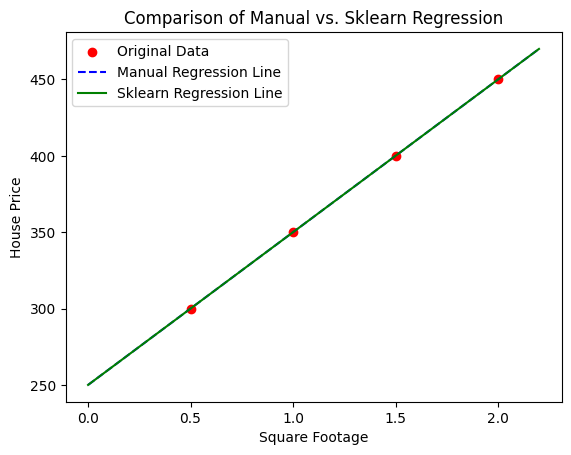

In [4]:
# Generate predictions using both models
X_plot = np.linspace(0, 2.2, 100).reshape(-1, 1)  # Extend X-axis to 0
X_plot_with_intercept = np.hstack((np.ones_like(X_plot), X_plot))  # Add intercept term

# Predictions
y_manual = X_plot_with_intercept @ beta_hat  # Manually computed model
y_sklearn = model.predict(X_plot_with_intercept)  # Sklearn model

# Scatter plot of original data
plt.scatter(X[:, 1], Y, color='red', label='Original Data')

# Plot regression lines
plt.plot(X_plot, y_manual, color='blue', linestyle='dashed', label='Manual Regression Line')
plt.plot(X_plot, y_sklearn, color='green', linestyle='solid', label='Sklearn Regression Line')

# Labels and legend
plt.xlabel('Square Footage')
plt.ylabel('House Price')
plt.title('Comparison of Manual vs. Sklearn Regression')
plt.legend()
plt.show()

The coefficients are equivalent when computed by hand with numpy computations and when computed with sklearn.

- What is the $\beta_0$ coefficient value?

- What is the $\beta_1$ coefficient value?

## Multiple Linear Regression Example
- Predict house price using more than one variable, both:
  - square footage; and
  - number of bedrooms
- Check assumptions and apply transformations if needed.

### Let's Start by Generating Data with Unequal Variance

In [5]:
# Load Ames Housing Dataset from OpenML
df = pd.read_csv("https://raw.githubusercontent.com/wblakecannon/ames/refs/heads/master/data/housing.csv")

# Select relevant features (Square Footage, Bedrooms, and SalePrice)
df = df[['Gr Liv Area', 'Bedroom AbvGr', 'SalePrice']].dropna()

# Rename columns for clarity
df.columns = ['SquareFootage', 'Bedrooms', 'MedianHousePrice']

# Introduce Heteroskedasticity: Noise scales with house price
np.random.seed(42)
heteroskedastic_noise = np.random.normal(0, 0.40 * df['MedianHousePrice'])

# Ensure house prices stay positive by setting a minimum price floor
df['MedianHousePrice_H'] = np.maximum(df['MedianHousePrice'] + heteroskedastic_noise, 50000)



### Split Data & Train Linear Regression Model

In [6]:
# Split data
X = df[['SquareFootage', 'Bedrooms']]
y = df['MedianHousePrice_H']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit Linear Model
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Calculate residuals
residuals = y_test - y_pred

# Calculate R² for the log-transformed model
r2_log = r2_score(y_test, y_pred)

print(f"R²: {r2_log:.4f}")

R²: 0.3370


Visualize the model

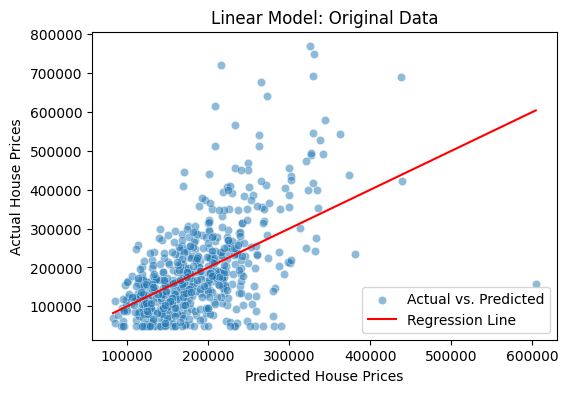

In [7]:
plt.figure(figsize=(6,4))
sns.scatterplot(x=y_pred, y=y_test, alpha=0.5, label="Actual vs. Predicted")
sns.lineplot(x=y_pred, y=y_pred, color='red', label="Regression Line")
plt.xlabel("Predicted House Prices")
plt.ylabel("Actual House Prices")
plt.title("Linear Model: Original Data")
plt.legend()
plt.show()

**Notice:** we no longer plot the x against the y here. This is because we now have more than one x. This type of visualization plots the predicted against the actual values of y.

Intuition with this visualization:

Imagine you're trying to estimate house prices. If your estimates perfectly match the real prices, all points fall on the diagonal.

If your estimates are too high or low in certain areas, those will appear off the diagonal, helping us diagnose issues.

What Are We Looking For?

A strong model:
- Points should be closely clustered around the diagonal 45-degree line (ideal case: y_actual = y_pred).
- This means the model's predictions are close to actual values.

Signs of Problems:
- Large deviations from the diagonal → Indicates the model struggles with certain values.
- A pattern in the residuals (e.g., curves, fanning out) → Suggests non-linearity or heteroskedasticity.
- Consistent under- or over-prediction in specific ranges → Indicates potential bias in the model.


Just for fun, let's create a 3-dimensional visualization of our model

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


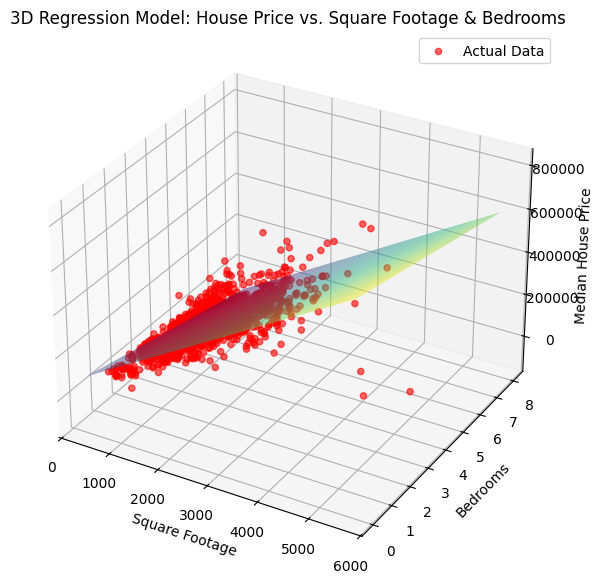

In [8]:
# Create a grid for visualization
sqft_range = np.linspace(df['SquareFootage'].min(), df['SquareFootage'].max(), 30)
bedroom_range = np.linspace(df['Bedrooms'].min(), df['Bedrooms'].max(), 30)
sqft_grid, bedroom_grid = np.meshgrid(sqft_range, bedroom_range)
X_grid = np.column_stack([sqft_grid.ravel(), bedroom_grid.ravel()])

# Predict prices over the grid
y_grid_pred = model.predict(X_grid)
y_grid_pred = y_grid_pred.reshape(sqft_grid.shape)

# 3D Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter actual data points
ax.scatter(df['SquareFootage'], df['Bedrooms'], df['MedianHousePrice'], color='red', label="Actual Data", alpha=0.6)

# Plot regression plane
ax.plot_surface(sqft_grid, bedroom_grid, y_grid_pred, cmap='viridis', alpha=0.5)

# Labels
ax.set_xlabel("Square Footage")
ax.set_ylabel("Bedrooms")
ax.set_zlabel("Median House Price")
ax.set_title("3D Regression Model: House Price vs. Square Footage & Bedrooms")

plt.legend()
plt.show()

### Check the Assumptions

1. Linearity Check

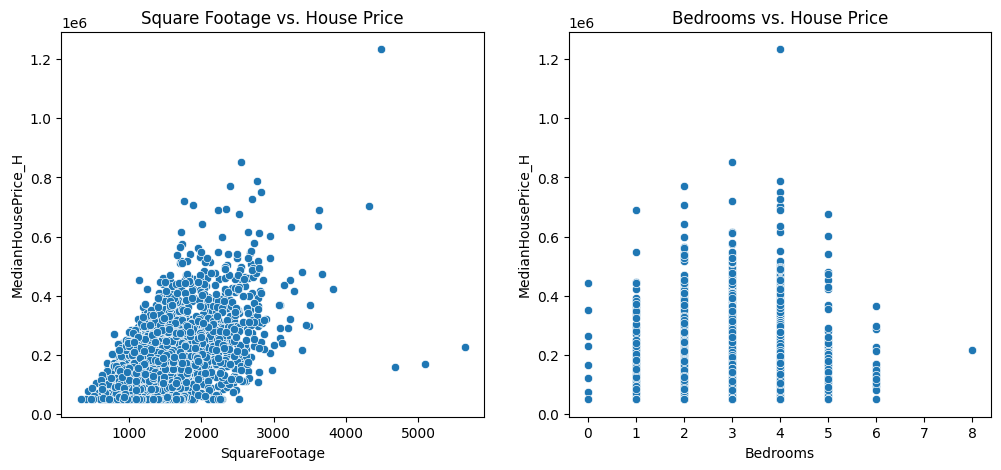

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.scatterplot(x=df['SquareFootage'], y=df['MedianHousePrice_H'], ax=axes[0])
axes[0].set_title("Square Footage vs. House Price")

sns.scatterplot(x=df['Bedrooms'], y=df['MedianHousePrice_H'], ax=axes[1])
axes[1].set_title("Bedrooms vs. House Price")
plt.show()

2. Multicollinearity Check

In [10]:
X_with_const = sm.add_constant(X_train)
vif_data = pd.DataFrame()
vif_data["Feature"] = X_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]
print("\nVariance Inflation Factor (VIF) BEFORE transformation:\n", vif_data)



Variance Inflation Factor (VIF) BEFORE transformation:
          Feature        VIF
0          const  14.824916
1  SquareFootage   1.379500
2       Bedrooms   1.379500


3. Normality of Residuals Check

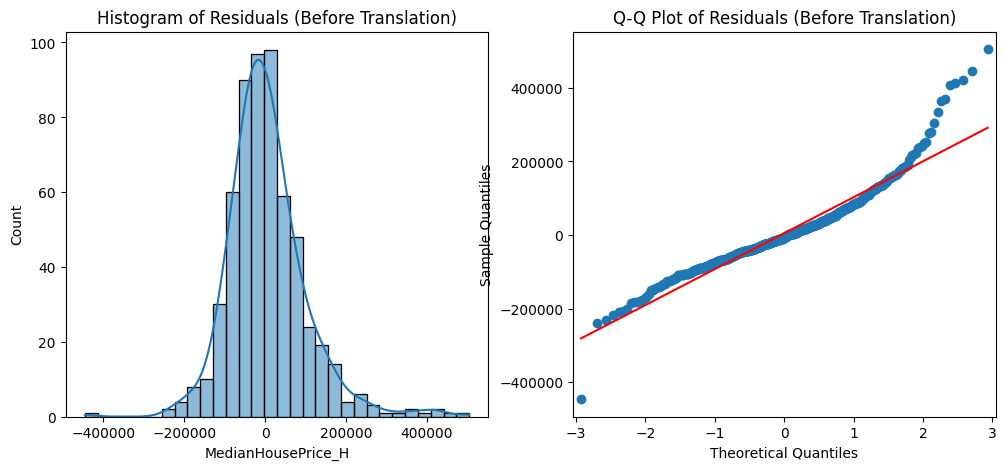

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(residuals, kde=True, bins=30, ax=axes[0])
axes[0].set_title("Histogram of Residuals (Before Translation)")

sm.qqplot(residuals, line='s', ax=axes[1])
axes[1].set_title("Q-Q Plot of Residuals (Before Translation)")
plt.show()

4. Homoskedasticity Check

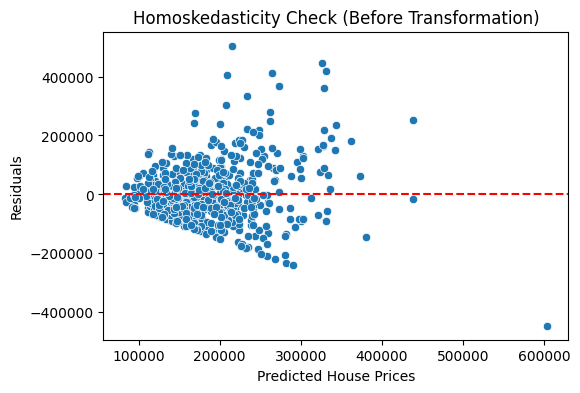

In [12]:
plt.figure(figsize=(6,4))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='red', linestyle='dashed')
plt.xlabel("Predicted House Prices")
plt.ylabel("Residuals")
plt.title("Homoskedasticity Check (Before Transformation)")
plt.show()

Explanation of Each Assumption Check

1. Linearity Check
- We scatterplot Y against each predictor (X).
- If the relationship is not linear, we may need transformations (log, polynomial).

2. Multicollinearity Check (VIF)
- Variance Inflation Factor (VIF) should be < 5.
- If VIF is high, predictors might be too correlated, and we should remove one.
- This metric gives us a sense of how inflated our uncertainty in our coefficients will be (square root of VIF will give us the uncertainty factor)

3. Normality of Residuals Check
- Histogram + Q-Q plot check if residuals follow a normal distribution.
- Non-normal residuals? Consider transforming Y or using a different model.

4. Homoskedasticity Check
- Residuals vs. Predicted scatterplot should show constant variance.
- If variance increases/decreases, data may be heteroskedastic (use log transformation).


### Apply Log Transformation

In [13]:
df['LogPrice'] = np.log(df['MedianHousePrice_H'])

# Split the log-transformed data
y_log = df['LogPrice']
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

# Fit a linear regression model on the log-transformed data
model_log = LinearRegression()
model_log.fit(X_train_log, y_train_log)
y_pred_log = model_log.predict(X_test_log)

# Calculate residuals for the log-transformed model
residuals_log = y_test_log - y_pred_log

# Calculate R² for the log-transformed model
r2_log = r2_score(y_test_log, y_pred_log)

print(f"R² for Log-Transformed Model: {r2_log:.4f}")

R² for Log-Transformed Model: 0.2769


**Notice**: R² is lower than before

In [14]:
# Calculate RMSE for the original model
rmse_original = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE (Original Model): {rmse_original:.4f}")

# Convert log predictions back to original scale
y_pred_log_original_scale = np.exp(y_pred_log)
y_test_log_original_scale = np.exp(y_test_log)

# Calculate RMSE in original scale
rmse_log_original = np.sqrt(mean_squared_error(y_test_log_original_scale, y_pred_log_original_scale))
print(f"RMSE (Log Model in Original Scale): {rmse_log_original:.4f}")

RMSE (Original Model): 97761.7570
RMSE (Log Model in Original Scale): 108380.4338


Our RMSE is also higher, more errors

Visualization of Linear Regression After Transformation

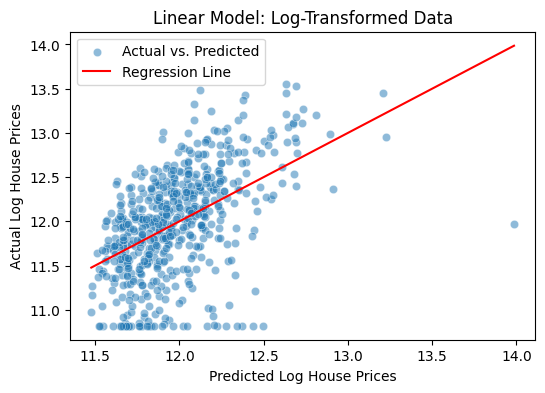

In [15]:
plt.figure(figsize=(6,4))
sns.scatterplot(x=y_pred_log, y=y_test_log, alpha=0.5, label="Actual vs. Predicted")
sns.lineplot(x=y_pred_log, y=y_pred_log, color='red', label="Regression Line")
plt.xlabel("Predicted Log House Prices")
plt.ylabel("Actual Log House Prices")
plt.title("Linear Model: Log-Transformed Data")
plt.legend()
plt.show()

### Assumption Checks After Transformation

1. Linearity Check

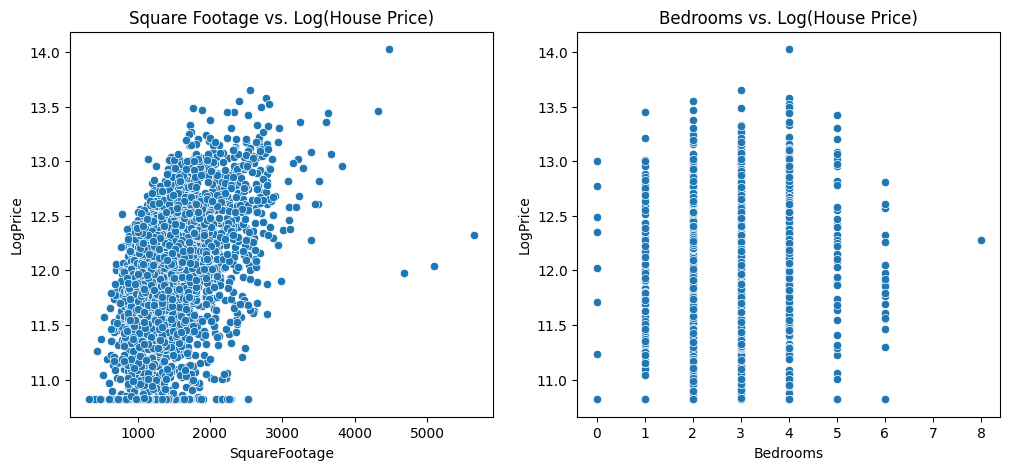

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.scatterplot(x=df['SquareFootage'], y=df['LogPrice'], ax=axes[0])
axes[0].set_title("Square Footage vs. Log(House Price)")

sns.scatterplot(x=df['Bedrooms'], y=df['LogPrice'], ax=axes[1])
axes[1].set_title("Bedrooms vs. Log(House Price)")
plt.show()

2. Multicolliinearity Check

In [17]:
X_with_const_log = sm.add_constant(X_train_log)
vif_data_log = pd.DataFrame()
vif_data_log["Feature"] = X_with_const_log.columns
vif_data_log["VIF"] = [variance_inflation_factor(X_with_const_log.values, i) for i in range(X_with_const_log.shape[1])]
print("\nVariance Inflation Factor (VIF) AFTER transformation:\n", vif_data_log)



Variance Inflation Factor (VIF) AFTER transformation:
          Feature        VIF
0          const  14.824916
1  SquareFootage   1.379500
2       Bedrooms   1.379500


3. Normality of Residuals

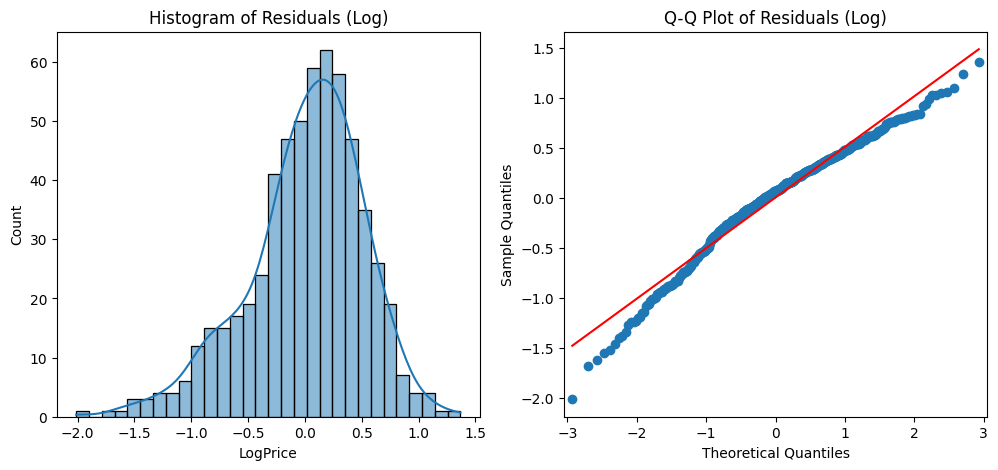

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(residuals_log, kde=True, bins=30, ax=axes[0])
axes[0].set_title("Histogram of Residuals (Log)")

sm.qqplot(residuals_log, line='s', ax=axes[1])
axes[1].set_title("Q-Q Plot of Residuals (Log)")
plt.show()

4. Homoskedasticity

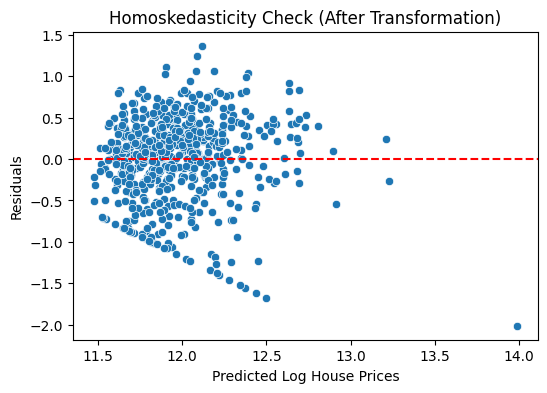

In [19]:
plt.figure(figsize=(6,4))
sns.scatterplot(x=y_pred_log, y=residuals_log)
plt.axhline(y=0, color='red', linestyle='dashed')
plt.xlabel("Predicted Log House Prices")
plt.ylabel("Residuals")
plt.title("Homoskedasticity Check (After Transformation)")
plt.show()

1. Evaluating the Log Transformation
- We applied a log transformation to house prices. What was the goal of this transformation? Did it achieve that goal?
- How did the log transformation affect R²? What does this tell us about how well the model explains variance?
- How did the log transformation affect RMSE? What does this tell us about actual prediction errors?
- Would we consider the log-transformed model “better”? Why or why not?

2. Interpreting the Results
- Our R² decreased after log transformation, but RMSE (in the original scale) increased as well.
- Given that RMSE measures prediction error, do you think the log transformation improved the practical usefulness of the model?

[Log transformation is not always helpful](https://stats.stackexchange.com/questions/336315/will-log-transformation-always-mitigate-heteroskedasticity)


# **Multiple Linear Regression on Ames Housing Data**
## **Exploring the Relationship Between Square Footage, Bedrooms, and House Prices**
In this exercise, we will:
- Load the Ames Housing dataset.
- Select relevant features (**Square Footage, Bedrooms, and Median House Price**).
- Fit a **multiple linear regression model**.
- Evaluate the model using **R² and RMSE**.

---
## **1. Load and Prepare the Data**

In [20]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Load Ames Housing Dataset from OpenML
df = pd.read_csv("https://raw.githubusercontent.com/wblakecannon/ames/refs/heads/master/data/housing.csv")

# Select relevant features (Square Footage, Bedrooms, and SalePrice)
df = df[['Gr Liv Area', 'Bedroom AbvGr', 'SalePrice']].dropna()

# Rename columns for clarity
df.columns = ['SquareFootage', 'Bedrooms', 'MedianHousePrice']

# Display first few rows
df.head()

,SquareFootage,Bedrooms,MedianHousePrice
0,1656,3,215000
1,896,2,105000
2,1329,3,172000
3,2110,3,244000
4,1629,3,189900


---
## **2. Explore the Data**
Before fitting a model, let's examine the data visually with a grid of pairplots of all three variables.

       SquareFootage     Bedrooms  MedianHousePrice
count    2930.000000  2930.000000       2930.000000
mean     1499.690444     2.854266     180796.060068
std       505.508887     0.827731      79886.692357
min       334.000000     0.000000      12789.000000
25%      1126.000000     2.000000     129500.000000
50%      1442.000000     3.000000     160000.000000
75%      1742.750000     3.000000     213500.000000
max      5642.000000     8.000000     755000.000000


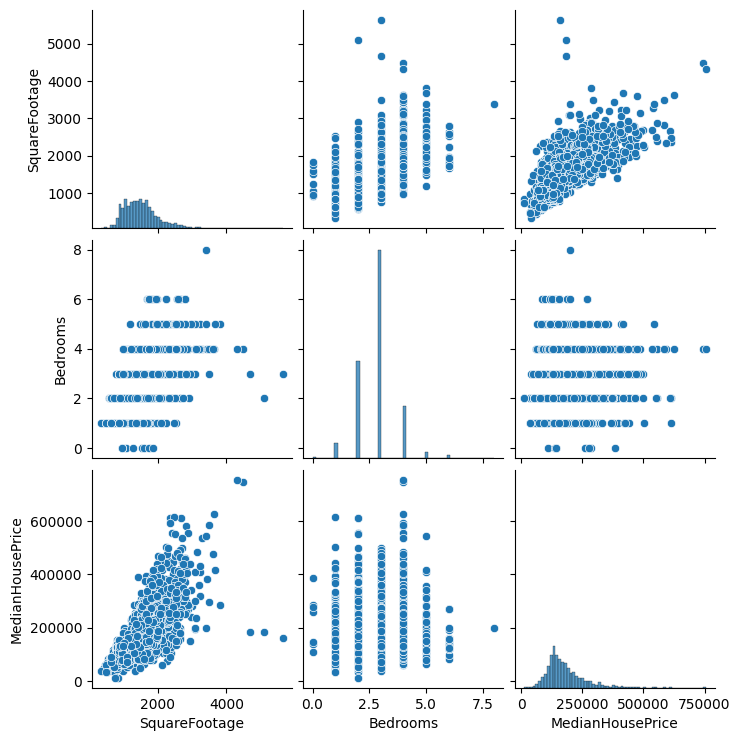

In [21]:
print(df.describe())
sns.pairplot(df)
plt.show()

---
## **3. Split Data into Training and Testing Sets**
To evaluate the model, we will split the dataset into:
- **Training Set (80%)** – used to train the model.
- **Testing Set (20%)** – used to assess how well the model generalizes.

In [22]:
X = df[['SquareFootage', 'Bedrooms']]
y = df['MedianHousePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## **4.1 Fit a Simple Linear Regression Model (Only Square Footage)**
Before building a multiple regression model, let's start with a **simple linear regression** using only **square footage** to predict house price.

**Question:**  
- Do you think adding **bedrooms** as an extra feature will improve predictions? Let's find out!

In [23]:
simple_model = LinearRegression()
simple_model.fit(X_train[['SquareFootage']], y_train)

y_pred_simple = simple_model.predict(X_test[['SquareFootage']])
r2_simple = r2_score(y_test, y_pred_simple)

print(f"Simple Linear Regression R²: {r2_simple:.4f}")

Simple Linear Regression R²: 0.5234


---
## **4.2 Fit a Multiple Linear Regression Model**
Now, let's train a multiple linear regression model using **square footage and number of bedrooms** to predict house price.

In [24]:
multi_model = LinearRegression()
multi_model.fit(X_train, y_train)

y_pred_multi = multi_model.predict(X_test)
r2_multi = r2_score(y_test, y_pred_multi)

print(f"Multiple Linear Regression R²: {r2_multi:.4f}")

Multiple Linear Regression R²: 0.5965


---
## **5. Evaluate the Model**
### **5.1 Calculate R² Score for the Multiple Linear Regression Model**
R² measures how much of the variance in house prices is explained by square footage and bedrooms.

In [25]:
print(f"R² Score for Multiple Linear Regression: {r2_multi:.4f}")

R² Score for Multiple Linear Regression: 0.5965


---
### **5.2 Calculate RMSE for the Multiple Linear Regression Model**
Root Mean Squared Error (RMSE) measures the average prediction error in the same units as the target variable (dollars).

In [31]:
rmse_multi = mean_squared_error(y_test, y_pred_multi)
print(f"RMSE for Multiple Linear Regression: ${np.sqrt(rmse_multi):,.2f}")

RMSE for Multiple Linear Regression: $56,878.90


---
### **5.3 Comparing R² for Simple vs. Multiple Regression**
Now, let's compare **R²** for:
1. **Simple Linear Regression (Square Footage Only)**
2. **Multiple Linear Regression (Square Footage + Bedrooms)**  

**Does adding the number of bedrooms improve the model’s ability to explain house price variance?**

In [33]:
print(f"Simple Linear Regression R²: {r2_simple:.4f}")
print(f"Multiple Linear Regression R²: {r2_multi:.4f}")

Simple Linear Regression R²: 0.5234
Multiple Linear Regression R²: 0.5965


```r2_multi > r2_simple```

 Adding bedrooms improved the model

---
## **6. Visualizing Performance of Both Models**
Let's plot the **predicted vs. actual house prices** to visually assess model fit of each model.

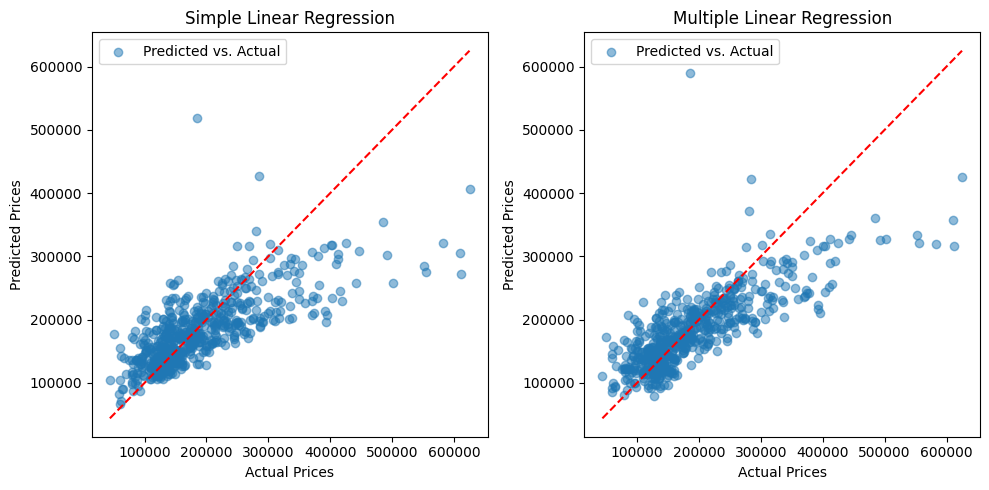

In [34]:
plt.figure(figsize=(10, 5))

# Simple Regression Plot
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_simple, alpha=0.5, label="Predicted vs. Actual")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Simple Linear Regression")
plt.legend()

# Multiple Regression Plot
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_multi, alpha=0.5, label="Predicted vs. Actual")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Multiple Linear Regression")
plt.legend()

plt.tight_layout()
plt.show()

In [36]:
improvement = r2_multi - r2_simple
print(f"R² Improvement: {improvement:.4f}")

R² Improvement: 0.0731
